# Generate Initial Conditions for Filament Simulations

In [20]:
import sys, os
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
    
from pyfilaments.activeFilaments import activeFilament
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
from sys import platform

from joblib import Parallel, delayed
import multiprocessing

# Check which platform
if platform == "linux" or platform == "linux2":
	print("linux system")
	root_path = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults'
	# root_path = '/home/deepak/Dropbox/LacryModeling/ModellingResults'
	

elif platform == 'darwin':
	print("OSX system")
	root_path = '/Users/deepak/Dropbox/LacryModeling/'

linux system


In [27]:
# Filament parameters
# Activity profile parameters
activity_timescale = 750
duty_cycle = 0.5

# No:of activity cycles we want to simulate
n_activity_cycles = 10
# Total simulation time
Tf = activity_timescale*n_activity_cycles

# Total simulation time
# No:of time points saved
time_step_save = 20
Npts = int(Tf/time_step_save)


bc = {0:'clamped', -1:'free'} # Filament BCs

DIM = 3
Np = 32
radius = 1
b0 = 2.1*radius
k = 25
S0 = 0
D0 = 1.5

# Filament activity sweep
fil = activeFilament(dim = DIM, Np = Np, radius = radius, b0 = b0, k = k, S0 = S0, D0 = D0, bc = bc)

# fil.simulate(Tf, Npts, n_cycles = n_activity_cycles, save = False, overwrite = False, path = root_path, 
#              sim_type = 'point', init_condition = {'shape':'line'}, 
# activity={'type':'square-wave','activity_timescale':activity_timescale, 'duty_cycle':duty_cycle, 'start phase':0})


In [14]:
import pyfilaments.analysisutils as analysis

# Import the filament as an Analysis object.
fil = analysis.analysisTools(filament = fil)

dict_keys(['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'weakref', 'collections.abc', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'mpl_toolkits', 'sphinxcontrib', 'runpy', 'pkgutil', 'ipykernel', 'ipykernel._version', 'ipykernel.connect', '__future__', 'json', 'json.decoder', 're', 'enum', 

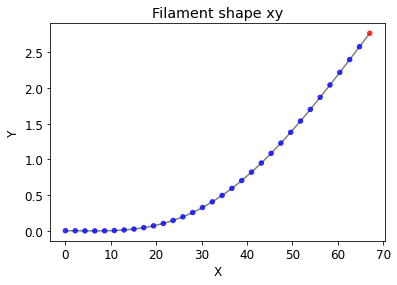

In [15]:
final_shape = fil.R[-1,:]
plt.figure()
fil.plotFilament(r = final_shape)

## Generate IC from the simulated filament shapes

In [24]:
import random

N_cycles = int(fil.Time[-1]/fil.activity_timescale)
N_transient = 0 # No:of activity cycles for transients to decay. 

N_IC_time = 10 # IC based on different activity cycles/time

# Choose n random activity cycles (time)
n_cycles = random.sample(range(N_transient, N_cycles), N_IC_time)

print(n_cycles)

time_points = np.array(range(0, len(fil.Time)))
# Find the index corresponding to each unique IC

# Create empty array to store indices for each unique IC
ic_mesh = np.empty(N_IC_time, dtype = int)

# Phase array for the whole simulation
phase_array = 2*np.pi*(fil.Time%fil.activity_timescale)/fil.activity_timescale
delta_phase = 2*np.pi*np.mean(fil.Time[1:] - fil.Time[:-1])/fil.activity_timescale # Smallest change in phase


phase = 0 # End of extension, Start of compression

    
print(phase)

abs_val_array = np.abs(phase_array  - phase)
constant_phase_mask = abs_val_array <= 0.5*delta_phase

time_indices = time_points[constant_phase_mask]

ic_mesh = time_indices[n_cycles]
    
    
print(ic_mesh)

[8, 7, 3, 9, 4, 1, 5, 2, 6, 0]
0
[300 263 113 338 150  38 188  75 225   0]


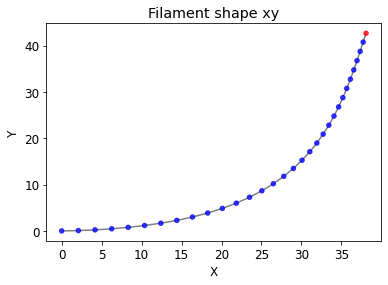

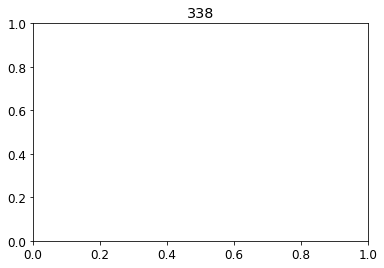

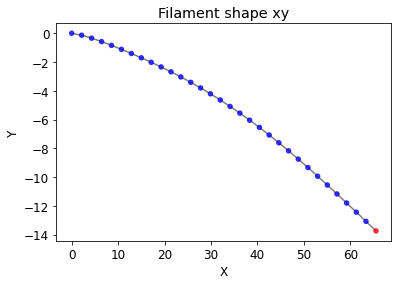

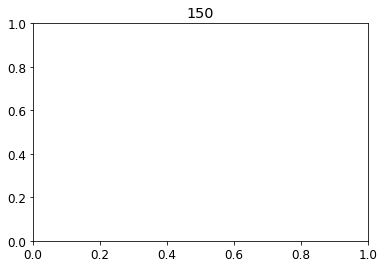

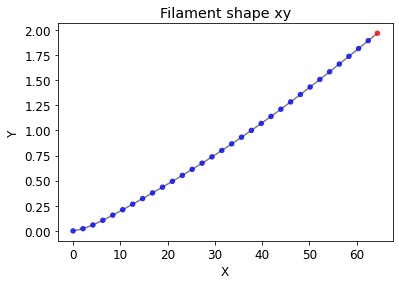

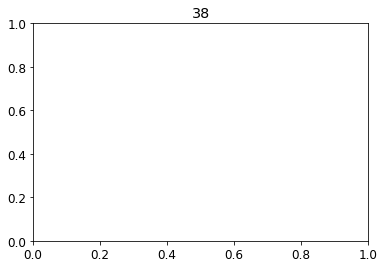

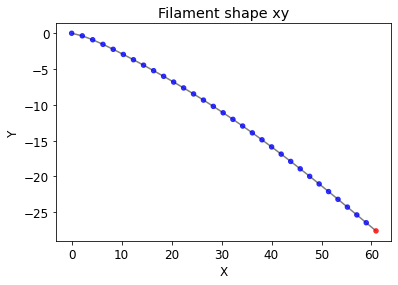

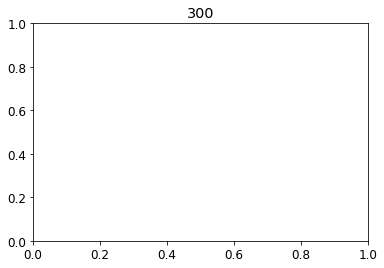

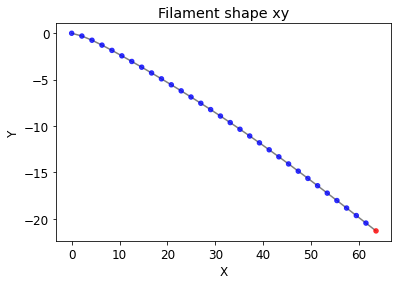

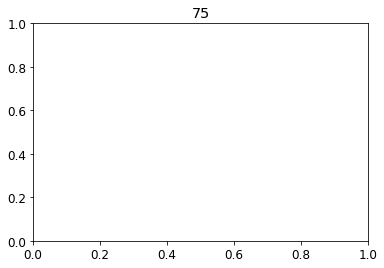

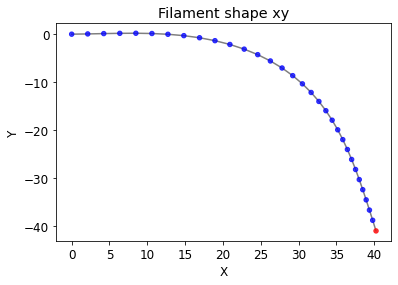

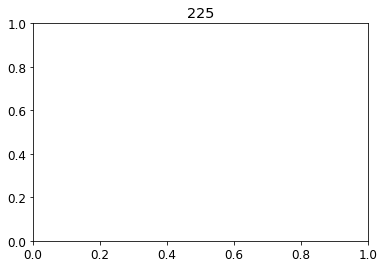

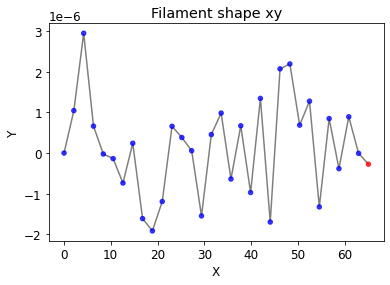

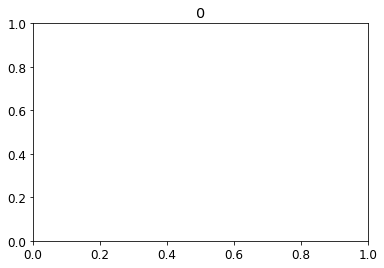

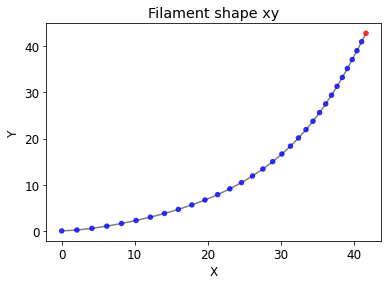

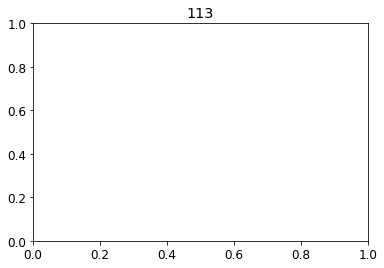

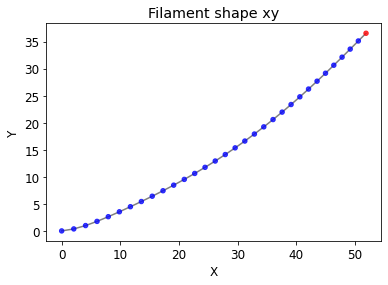

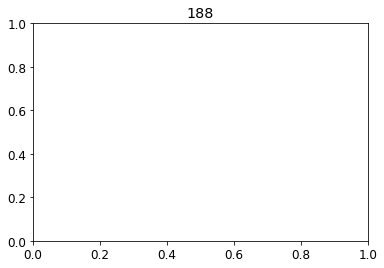

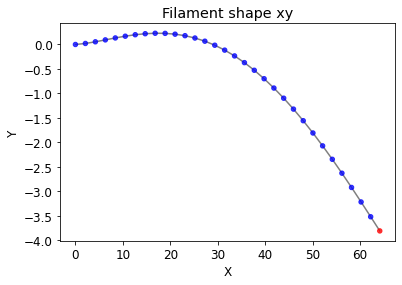

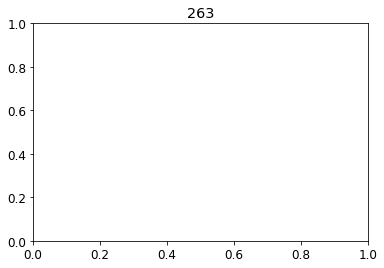

In [22]:
import h5py


filament_init_shape = np.zeros(fil.Np*fil.dim, dtype = np.double)

ic_folder = os.path.join(fil.saveFolder, 'InitialConditions')

if not os.path.exists(ic_folder):
    os.makedirs(ic_folder)
    
for ii in range(N_IC_time):
    
        
    time_index = ic_mesh[ii]

    phase = phase_array[time_index]




    filament_init_shape = fil.R[time_index,:]

    plt.figure()
    fil.plotFilament(r = filament_init_shape)
    plt.title(time_index)


    save_file = 'filament_ic_{0:03d}'.format(ii)


    # Save the resulting filament shapes to disk
    with h5py.File(os.path.join(ic_folder, save_file), "w") as f:

        dset = f.create_group("simulation data")
        dset.create_dataset("Initial Position", data = filament_init_shape)
        dset.attrs['Time index'] = time_index
        # Also save the phase value of the simulation
        dset.attrs['Phase'] = phase

In [ ]:
## Run filament simulation using these initial conditions
# No:of activity cycles we want to simulate
n_activity_cycles = 100
# Total simulation time
Tf = fil.activity_timescale*n_activity_cycles

# activity_timescale = 1000

# Total simulation time
# No:of time points saved
time_step_save = 20
Npts = int(Tf/time_step_save)

bc = {0:'clamped', -1:'free'}

dim = fil.dim
Np = fil.Np
radius = fil.radius
b0 = fil.b0
k = fil.k
S0 = fil.S0
D0 = fil.D0
activity_timescale = fil.activity_timescale


def run_parametric_simulation(parameter_value):
    
    # Generate the Initial Conditions for given parameter value
    # Check if it 
    
    
    # Simulate each IC
    new_fil = activeFilament(dim = dim, Np = Np, radius = radius, b0 = b0, k = k, S0 = S0, D0 = D0, bc = bc)

    new_fil.simulate(Tf, Npts, n_cycles = n_activity_cycles, save = True, overwrite = False, path = path, sim_type = 'point', 
    init_condition = {'filament':filament_shape}, 
    activity={'type':'square-wave','activity_timescale':activity_timescale, 'duty_cycle':0.5, 'start phase':phase},
                note = ic, create_subdirs=False)

[0.737798274706694, -0.3569991651806583, 0.03966657390896211, -0.7695315338338634, -0.26179938779914935, 0.30939927648990384, 0.6267318677616003, 0.563265349507261, 0.11899972172688611, -0.1983328695448101]


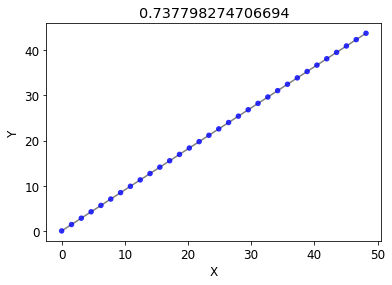

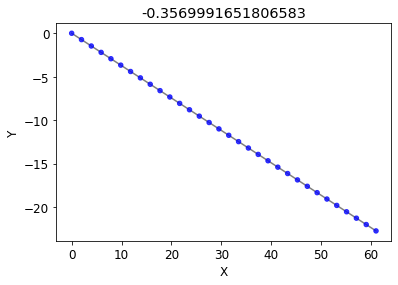

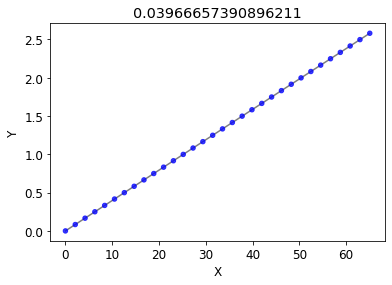

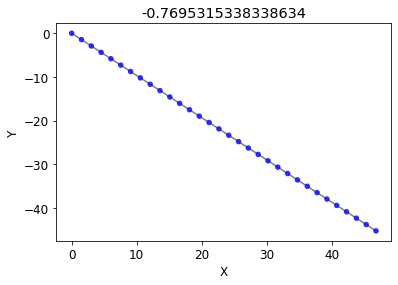

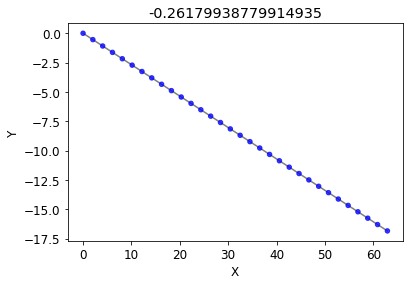

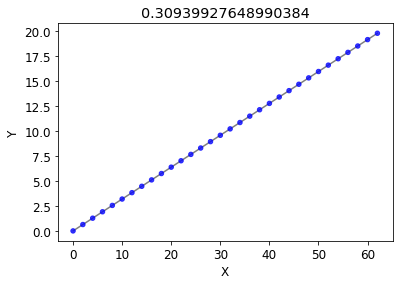

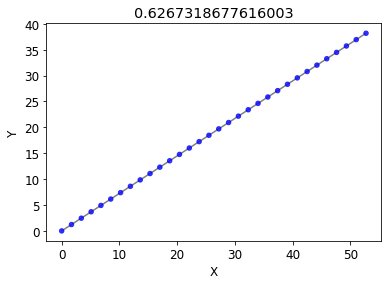

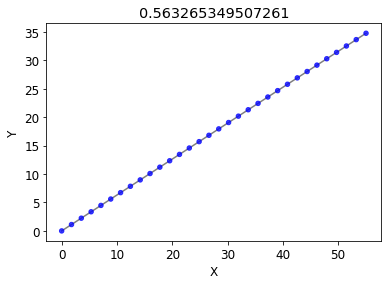

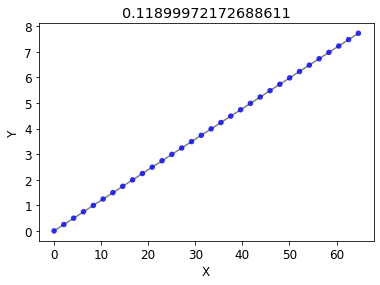

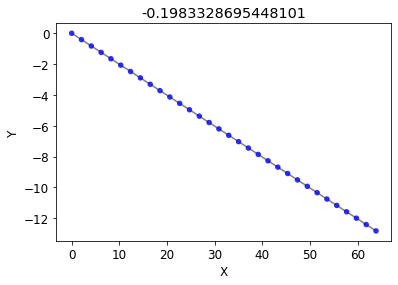

In [31]:
# generate random ICs based on filament angle

filament_init_shape = np.zeros(fil.Np*fil.dim, dtype = np.double)


# generate N random angles within the filament angular amplitude range
N_IC = 10
angle = np.pi/4
N_angles = 100
angles_array = np.linspace(-angle, angle, N_angles)

random_angles = random.sample(list(angles_array), N_IC)

print(random_angles)


for angle in random_angles:
 
    # generate filament shapes based on these angles
    for ii in range(fil.Np):
        fil.r0[ii] = ii*(fil.b0)*np.cos(angle)
        fil.r0[fil.Np+ii] = ii*(fil.b0)*np.sin(angle) 
        
    filament_init_shape = fil.r0
    
   
    fil.plotFilament(r = filament_init_shape, title = angle)
  